Fix the seeds

In [1]:
import numpy as np
import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Dataset

In [2]:
import torch
from scipy.linalg import hadamard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), '\n')

torch.set_default_dtype(torch.float64) # very small numbers

# Creating Hadamard matrix, where each row is 32x32 hadamard pattern with {-1,1} elements
px = 32
H = torch.from_numpy(hadamard(px**2)).to(device)
# In real (physical) single pixel measurements we use matrixes
Hplus = (H + 1) / 2
Hminus = (1 - H) / 2

Cuda available:  False 



Here are the functions, which create measurements vectror for all patterns in Hadamard basis

In [3]:
def measurement(img):
    Mplus = torch.matmul(Hplus, img.flatten()).to(device)
    Mminus = torch.matmul(Hminus, img.flatten()).to(device)
    M = (Mplus - Mminus)

    return M

In [4]:
def batch_measurements(imgs):
    vect = torch.zeros(len(imgs), len(imgs[0]) ** 2)

    for i in range(len(imgs)):
        img = imgs[i].to(device)
        vect[i] = measurement(img)

    return vect

Short cut dataset with single-pixel measuarements and target images (640 zeros and 640 ones)

In [7]:
from torchvision import transforms
from torch.utils.data.dataset import Dataset

class MeasurementsDataset(Dataset):
    def __init__(self, mnist):
        super().__init__()
        
        if mnist.train:
            num = 640
        else:
            num = 128
        
        self.labels = mnist.targets
        images = torch.cat([mnist.data[mnist.targets == 0][:num], mnist.data[mnist.targets == 1][:num]])
        transform = transforms.Compose([transforms.ConvertImageDtype(torch.float64),
                                        transforms.Resize((px,px))])

        images = transform(images)
        self.target_images = (images - images.min()) / (images.max() - images.min())

        self.measurements = batch_measurements(self.target_images).cpu()

    def __getitem__(self, indx):
        return self.measurements[indx], self.target_images[indx]

    def __len__(self):
        return len(self.measurements)

In [8]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

train_set = MeasurementsDataset(MNIST(root='./data', train=True, download=True))
test_set = MeasurementsDataset(MNIST(root='./data', train=False, download=True))

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

clear_output()

To create an underdefined system of equlations we need to select the most important ones, so we need to calculate variance

In [9]:
import numpy as np

variance = np.array([])
for i in range(1024):
    measurements_for_pattern = train_set[:][0][:,i]
    variance = np.append(variance, np.var(measurements_for_pattern.numpy()))

The most important patterns - with biggest dispersion trough the dataset

In [10]:
most_important = np.argsort(variance)[-64:]

# Model

In [14]:
import pennylane as qml

num_qubits = int(np.ceil(np.log2(px * px))) # 10
num_layers = 30

dev = qml.device("default.qubit", wires=num_qubits)

Creating variational quantum circuit

In [15]:
def layer(W, flag=None):
    for i in range(num_qubits):
        qml.RY(W[i], wires=i)
    if (flag != 'last'):
        for j in range(num_qubits - 1):
            qml.CNOT(wires=[j, j + 1])

In [16]:
@qml.qnode(dev, interface="torch")
def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, wires=range(6), pad_with=0.0, normalize=True)
    qml.BasisState(np.array([0, 0, 0, 0]), wires=range(6,10))
    qml.Barrier(list(range(num_qubits))) # for drawing

    for i, W in enumerate(weights):
        if i < len(weights) - 1:
            layer(W)
        else:
            layer(W, 'last')
        qml.Barrier(list(range(num_qubits)))

    return qml.probs() # probabilities

In [17]:
def variational_circuit(q_circuit, params, feat):
    angles = params[0].cpu()
    return q_circuit(angles, feat=feat)

How it's look like (state preparation, one layer and measurements)

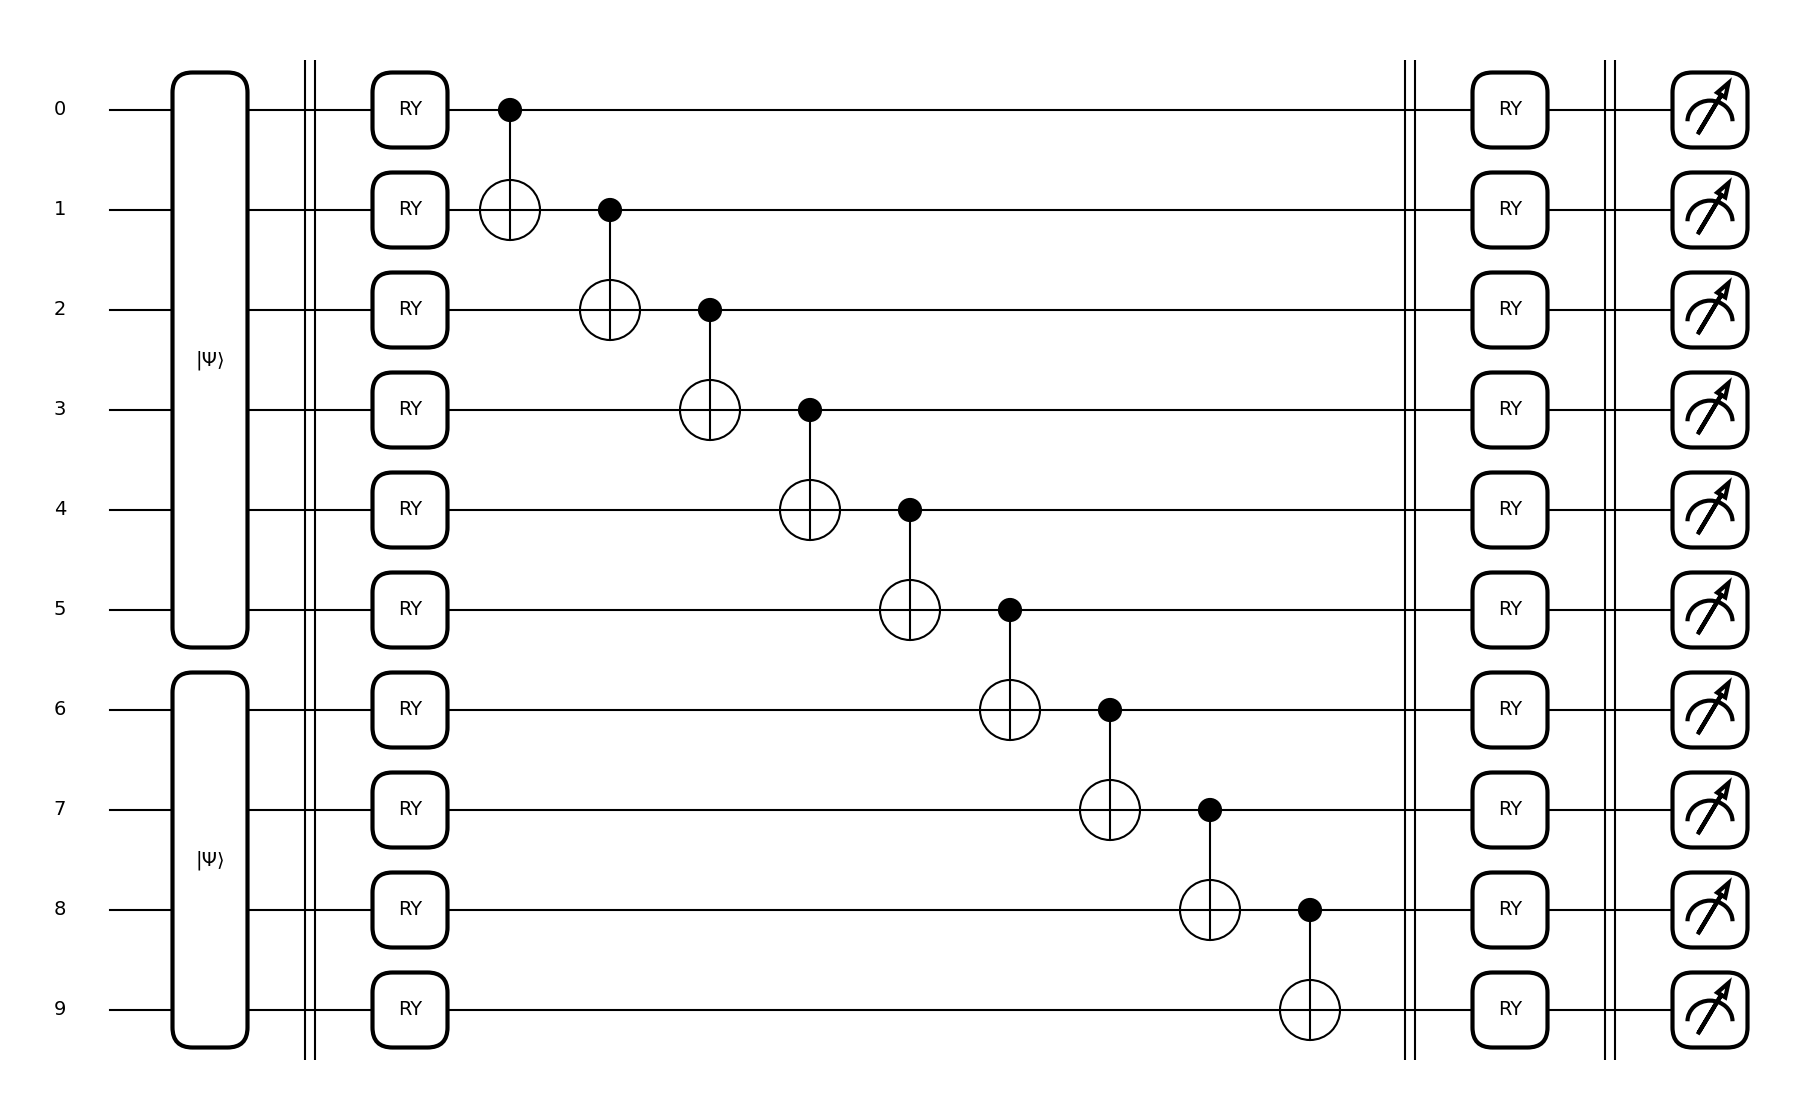

In [18]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

all_weights = Variable(0.1 * torch.randn(1 + 1, num_qubits).to(device), requires_grad=True)
features = torch.randn(64)
params = (all_weights,)

fig, ax = qml.draw_mpl(circuit)(params[0], features)
plt.show()

In [19]:
# Training

Class for plots

In [17]:
from collections import defaultdict
import matplotlib.pyplot as plt

class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="best")
        if history_len < 20:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(24 // n_groups, 5))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Loss

In [18]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

def loss_function(q_circuit, params, feature_vecs, target_images):
    
    loss = 0.0
    num_samples = len(target_images)
    
    for i in range(num_samples):
        
        process_image = variational_circuit(q_circuit, params, feature_vecs[i].to(device))
        
        # make images to be in the same range of values and shape
        process_image = process_image / process_image.max()
        target_image = target_images[i].cpu().flatten()
        
        loss += torch.sum((target_image - process_image) ** 2) / (px ** 2) # MSE

    loss /= num_samples

    return loss

Training

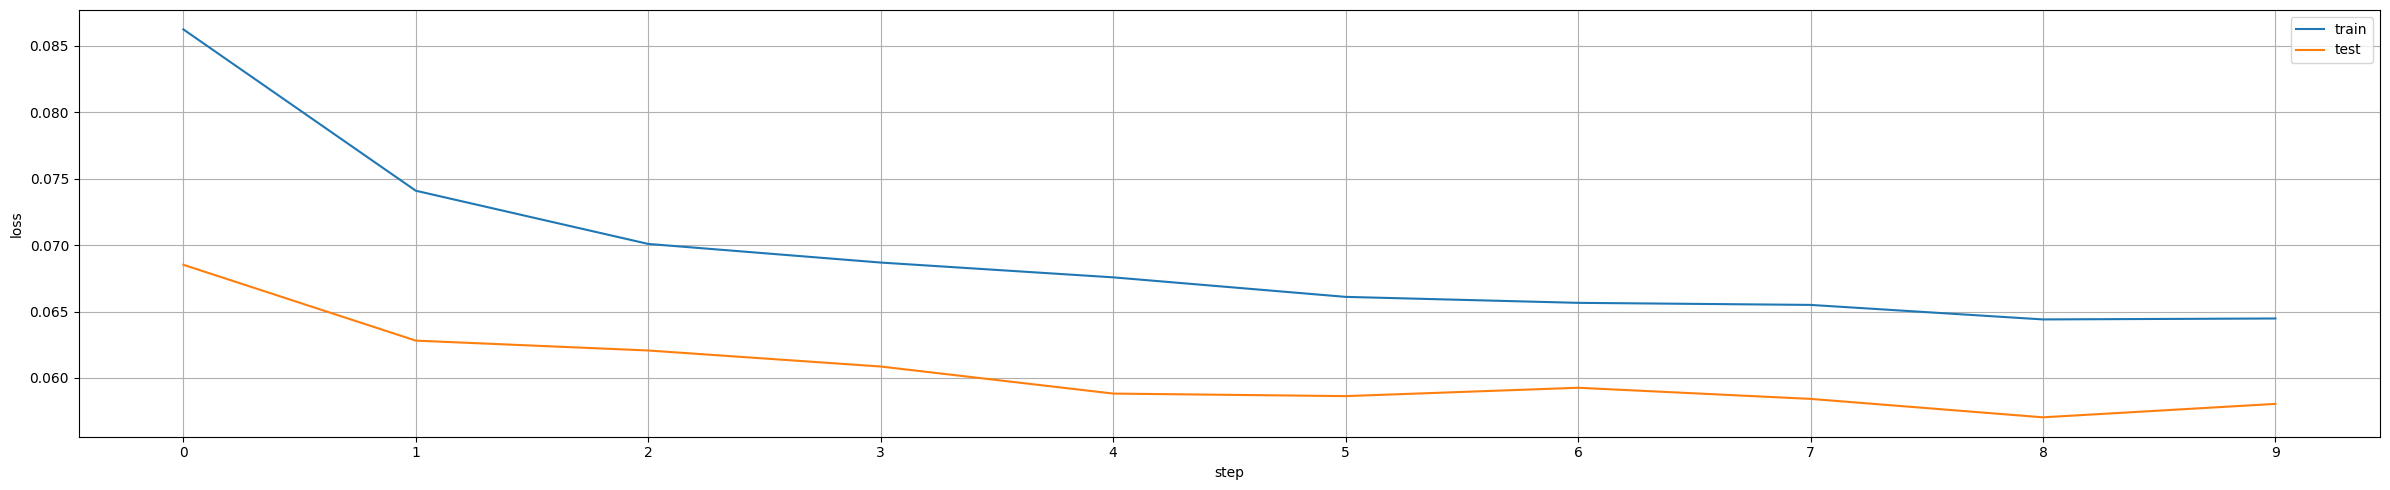

CPU times: total: 1h 40min 59s
Wall time: 1h 37min 59s


In [19]:
%%time
from torch.autograd import Variable
import torch.optim as optim

lr = 0.01
num_epoch = 10
device = torch.device("cpu")
pp = ProgressPlotter(groups=['loss'])

# random parameters initialization
weights = Variable(0.1 * torch.randn(num_layers + 1, num_qubits).cpu(), requires_grad=True)
print("Num params: ", num_qubits * (num_layers + 1))

params = (weights,)
optimizer = optim.Adam(params, lr=lr)

q_circuit = qml.QNode(circuit, dev, interface="torch")
batches_num = len(train_loader)

# train the variational classifier
for e in range(num_epoch):
    train_loss = 0
    for i, batch in enumerate(train_loader):
        measurements, target_imgs = batch
        measurements, target_imgs = measurements.cpu(), target_imgs.cpu()

        optimizer.zero_grad()

        curr_cost = loss_function(q_circuit, params, measurements[:, most_important], target_imgs)

        curr_cost.backward()
        optimizer.step()
        
        l = curr_cost.detach().cpu().numpy()
        train_loss += l

        print(f"Train: Epoch {e}, batch #{i+1}/{len(train_loader)}, loss={l}")

    train_loss /= len(train_loader)
    
    val_loss = 0
    for i, batch in enumerate(test_loader):
        process_imgs, target_imgs = batch
        process_imgs, target_imgs = process_imgs.cpu(), target_imgs.cpu()

        curr_cost = loss_function(q_circuit, params, process_imgs[:,most_important], target_imgs)
        
        l = curr_cost.detach().cpu().numpy()
        val_loss += l

        print(f"Validation: Epoch {e}, batch #{i+1}/{len(test_loader)}, loss={l}")

    val_loss /= len(test_loader)
    
    pp.add_scalar('loss', train_loss, 'train')
    pp.add_scalar('loss', val_loss, 'test')
    pp.display()

In [20]:
print(pp.history_dict["loss"]["train"])

[0.08622508664499359, 0.07408681519585089, 0.07008409770373708, 0.06868386101694476, 0.06757078662081248, 0.0661017279980354, 0.06565280247839744, 0.06549724120466086, 0.06440502812212204, 0.06447555033004922]


In [21]:
print(pp.history_dict["loss"]["test"])

[0.06851604527883583, 0.06280999415243949, 0.06206804629769856, 0.06086260070961308, 0.05882625120262054, 0.058635327313438707, 0.059264070593299564, 0.05842681042763224, 0.05703971528338962, 0.058050643200976096]


In [22]:
pred_0 = torch.tensor([])
pred_1 = torch.tensor([])

measurements_0, target_imgs_0 = next(iter(test_loader))

for batch in test_loader:
    measurements_1, target_imgs_1 = batch

for i in range(batch_size):
    pred_0 = torch.cat((pred_0, variational_circuit(q_circuit, params, measurements_0[i][most_important].to(device)).detach().unsqueeze(0)), 0)
    pred_1 = torch.cat((pred_1, variational_circuit(q_circuit, params, measurements_1[i][most_important].to(device)).detach().unsqueeze(0)), 0)

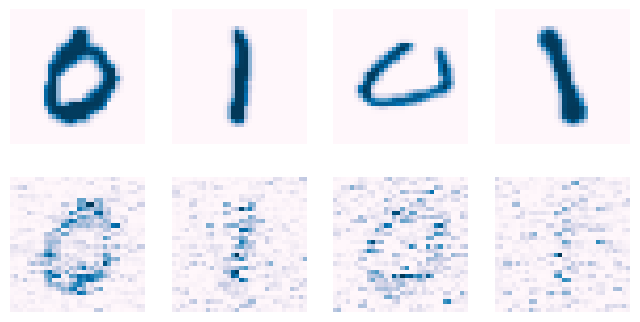

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))

targets = [target_imgs_0[0], target_imgs_1[0], target_imgs_0[40], target_imgs_1[61]]
predictions = [pred_0[0], pred_1[0], pred_0[40], pred_1[61]]

vmin = 0
vmax = 1

for i in range(4):
    
    target_image = targets[i].reshape(32,32).numpy()
    predicted_image = predictions[i] / predictions[i].max()
    predicted_image = predicted_image.reshape(32,32)
    
    axs[0,i].set_axis_off()
    axs[1,i].set_axis_off()

    img = axs[0,i].imshow(target_image, vmin=vmin, vmax=vmax, cmap="PuBu")
    img = axs[1,i].imshow(predicted_image, vmin=vmin, vmax=vmax, cmap="PuBu")
    
# fig.colorbar(img, ax=axs[:,:])
plt.savefig(f"images/{num_layers}_layers_{lr}_lr.eps")

In [24]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

s = 0
ssim = StructuralSimilarityIndexMeasure()

target_imgs_0 = target_imgs_0.reshape(batch_size, 1, px, px)
target_imgs_1 = target_imgs_1.reshape(batch_size, 1, px, px)
    
pred_0 = pred_0.reshape(batch_size, 1, px, px)
pred_1 = pred_1.reshape(batch_size, 1, px, px)
    
s += ssim(pred_0, target_imgs_0)
s += ssim(pred_1, target_imgs_1)
s /= 2
print(s)

tensor(0.2520)
